In [2]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

# List kaggle folders

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./JUGE_Vincent_documentation_et_code_112022.ipynb
./output.png
./JUGE_Vincent_presentation_112022.pdf
./JUGE_Vincent_lien_kernel_kaggle_112022.txt
./index.md
./submission.csv
./module-p8.ipynb
./JUGE_Vincent_Rapport_112022.pdf
./JUGE_Vincent_P8_112022.zip
./P8_Soutenance.pdf
./data/stores.csv
./data/oil.csv
./data/transactions.csv
./data/holidays_events.csv
./data/train.csv
./data/train_filled.csv
./data/test.csv
./data/sample_submission.csv


In [4]:
#!pip install "gluonts[mxnet,pro]"

In [5]:
# desactivate removal of outliers and scaling of data, since it gives worste results

REMOVE_OUTLIERS = False
SCALE_DATA = False

## EDA

In [6]:
from datetime import datetime

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_test.date.min()
df_test.date.max()
min = datetime.strptime(df_test.date.min(), '%Y-%M-%d')
max = datetime.strptime(df_test.date.max(), '%Y-%M-%d')




'2017-08-16'

'2017-08-31'

In [7]:
df_train
df_train.shape
df_train.date.min()
df_train.date.max()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


(3000888, 6)

'2013-01-01'

'2017-08-15'

dataset starts from 2013-01-01 to 2017-08-15

predictions must be made from 2017-08-16 to 2017-08-31


In [8]:
df_train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

Do we have continuous dates ?

no : 25 december is missing for all


In [9]:
df_train.groupby(by=['date']).count()

df_train[df_train['date'] == '2013-12-24']
df_train[df_train['date'] == '2013-12-25']

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,1782,1782,1782,1782,1782
2013-01-02,1782,1782,1782,1782,1782
2013-01-03,1782,1782,1782,1782,1782
2013-01-04,1782,1782,1782,1782,1782
2013-01-05,1782,1782,1782,1782,1782
...,...,...,...,...,...
2017-08-11,1782,1782,1782,1782,1782
2017-08-12,1782,1782,1782,1782,1782
2017-08-13,1782,1782,1782,1782,1782


,id,date,store_nbr,family,sales,onpromotion
636174,636174,2013-12-24,1,AUTOMOTIVE,1.000,0
636175,636175,2013-12-24,1,BABY CARE,0.000,0
636176,636176,2013-12-24,1,BEAUTY,2.000,0
636177,636177,2013-12-24,1,BEVERAGES,1248.000,0
636178,636178,2013-12-24,1,BOOKS,0.000,0
...,...,...,...,...,...,...
637951,637951,2013-12-24,9,POULTRY,848.844,0
637952,637952,2013-12-24,9,PREPARED FOODS,40.000,0
637953,637953,2013-12-24,9,PRODUCE,0.000,0
637954,637954,2013-12-24,9,SCHOOL AND OFFICE SUPPLIES,0.000,0


,id,date,store_nbr,family,sales,onpromotion


### Fill missing dates


On each December 25, for each store and each category, set 'sales' to 0



In [10]:
# add missing dates to train dataset : required for fitting the model

un_store = df_train['store_nbr'].unique()
un_family = df_train['family'].unique()

tmp_df = pd.DataFrame(
    columns=['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'],
    )

for i, s in enumerate(un_store):
    for j, f in enumerate(un_family):
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2013-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True,
        )
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2014-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True
        )
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2015-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True
        )
        tmp_df = tmp_df.append(
            pd.DataFrame(
                {'id': 0, 'date': '2016-12-25', 'store_nbr': s, 'family': f, 'sales': 0, 'onpromotion' : 0},
                index=[0]),
            ignore_index=True
        )

tmp_df
df_train = df_train.append(tmp_df)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-12-25,1,AUTOMOTIVE,0,0
1,0,2014-12-25,1,AUTOMOTIVE,0,0
2,0,2015-12-25,1,AUTOMOTIVE,0,0
3,0,2016-12-25,1,AUTOMOTIVE,0,0
4,0,2013-12-25,1,BABY CARE,0,0
...,...,...,...,...,...,...
7123,0,2016-12-25,9,SCHOOL AND OFFICE SUPPLIES,0,0
7124,0,2013-12-25,9,SEAFOOD,0,0
7125,0,2014-12-25,9,SEAFOOD,0,0
7126,0,2015-12-25,9,SEAFOOD,0,0


In [11]:
df_train = df_train.astype({
    'id': 'int64',
    'store_nbr': 'int64',
    'sales': 'float',
    'onpromotion': 'int64'
})
# df_train.to_csv('data/train_filled.csv')


### Categorical Values 


Eventually encode categorical feature, maybe usefull for the model

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_train['family_cat'] = le.fit_transform(df_train['family'])
le.classes_
len(le.classes_)

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR WINE BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

33

In [13]:
nb_stores = df_train['store_nbr'].unique()
nb_stores
len(nb_stores)

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

54

In [14]:
df_test['family_cat'] = le.fit_transform(df_test['family'])
df_test

,id,date,store_nbr,family,onpromotion,family_cat
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0
1,3000889,2017-08-16,1,BABY CARE,0,1
2,3000890,2017-08-16,1,BEAUTY,2,2
3,3000891,2017-08-16,1,BEVERAGES,20,3
4,3000892,2017-08-16,1,BOOKS,0,4
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,28
28508,3029396,2017-08-31,9,PREPARED FOODS,0,29
28509,3029397,2017-08-31,9,PRODUCE,1,30
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,31


### Data Preparation

#### Outliers

(Optionnal) : remove outliers of dataset.

note: if activated, submission to kaggle gives worse result than without

In [15]:
def dropOutlierIQR(df, col):
    """removes outliers of dataframe following IQR method, and set the value to median

    Args:
        df (pandas.Dataframe): dataframe
        col (string): column to remove outliers
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    med = np.median(df[col])
    df[col] = df[col].apply(lambda x: x if ((x > (Q1 - 1.5 * IQR)) & (x < (Q3 + 1.5 * IQR))) else med)
    return df


In [16]:
# apply to all catagories
import matplotlib.pyplot as plt

# desactivate
if REMOVE_OUTLIERS : 
    for cat in le.classes_:
        df_tmp = df_train[df_train['family'] == cat]
        df_train[df_train['family'] == cat] = dropOutlierIQR(df_tmp, 'sales')


<AxesSubplot:title={'center':'sales'}, xlabel='family'>

<AxesSubplot:title={'center':'sales'}, xlabel='family'>

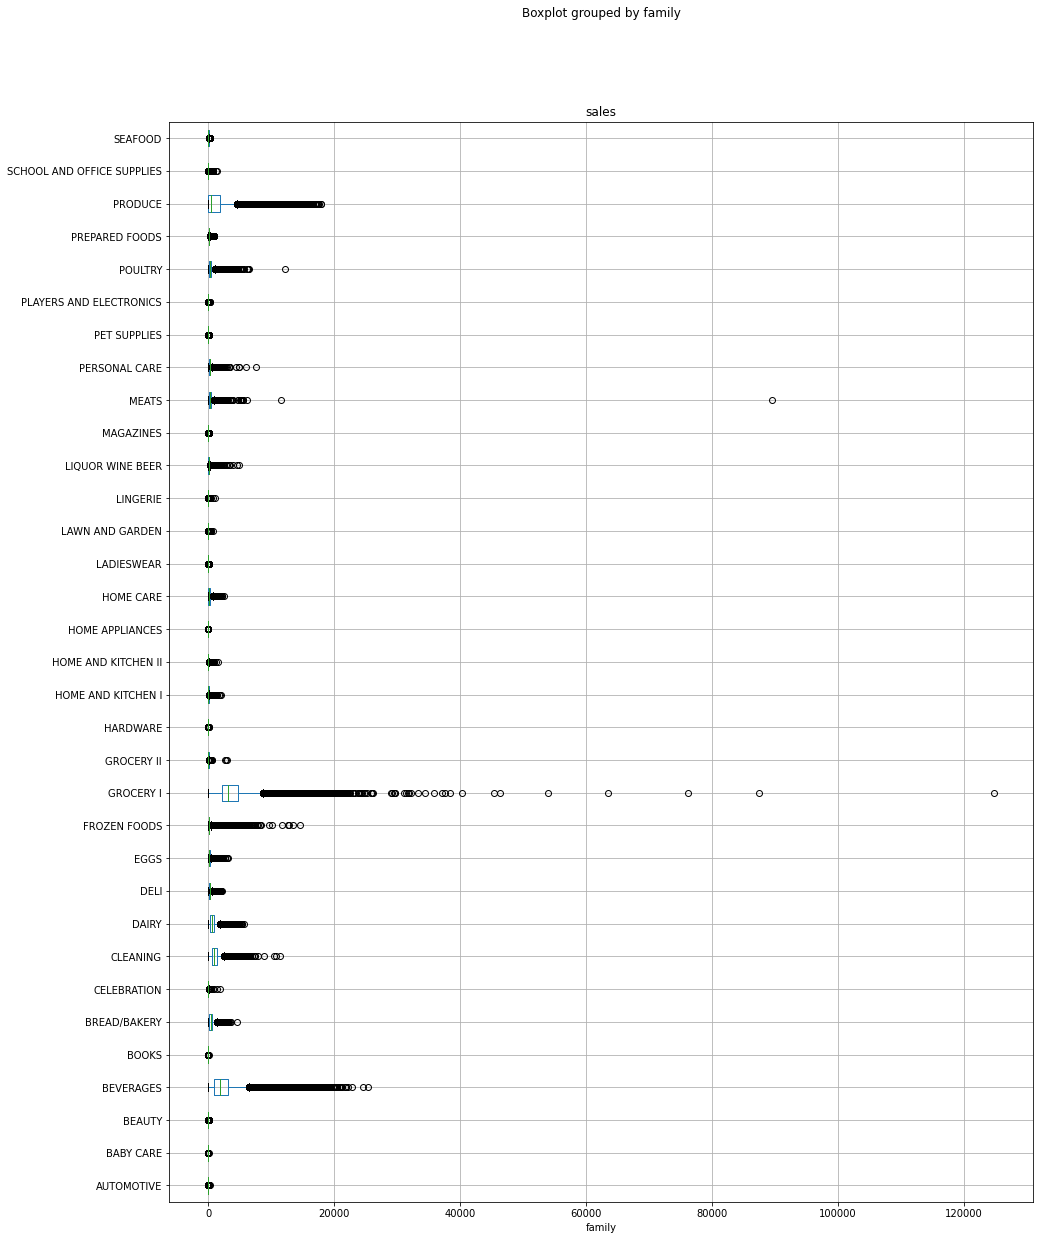

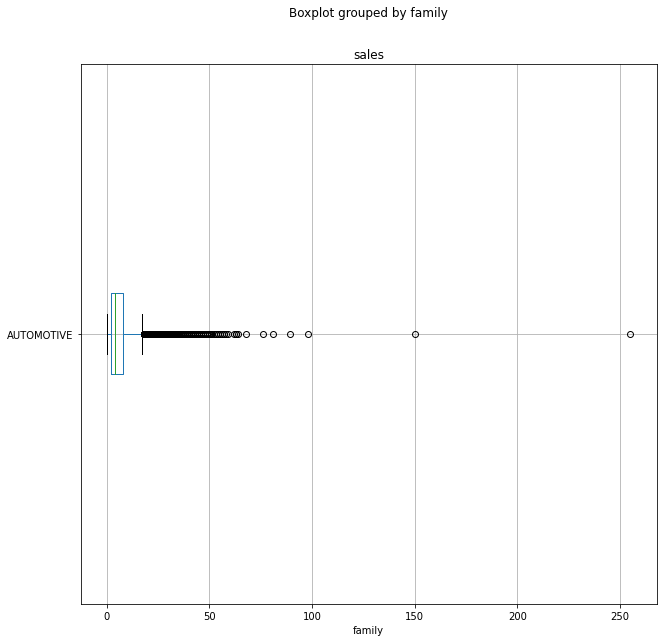

In [17]:

df_train.boxplot(column=['sales'], by='family', vert=False, figsize=(15,20))
df_train[df_train['family'] == 'AUTOMOTIVE'].boxplot(column=['sales'], by='family', vert=False, figsize=(10,10))



#### Scaling

Apply MinMax Scaler to each family

In [18]:
from sklearn.preprocessing import MinMaxScaler

def fit_all_scalers(df, col, target):
    """scale dataframe and returns scaler following a given category

    Args:
        df (pandas.Dataframe): dataframe to scale
        col (string): column of the categories to filter dataframe
        target (string): target column to scale, following the category

    Returns:
        _type_: dict of scalers for each category
    """
    categories = np.unique(df[col])
    scalers = []
    for cat in categories:
        scaler = MinMaxScaler()
        to_scale = df[df[col] == cat][target]
        df.loc[df[col] == cat, target] = scaler.fit_transform(np.array(to_scale).reshape(-1,1))
        scalers.append({col: cat, 'scaler': scaler})
    return scalers

def unscale(df, scalers, col, target):
    categories = np.unique(df[col])
    for cat in categories:
        scaler = [item for item in scalers if item['family'] == cat][0]['scaler']
        to_scale = df[df[col] == cat][target]
        df.loc[df[col] == cat, target] = scaler.inverse_transform(np.array(to_scale).reshape(-1,1))


In [19]:
# testing
# df_tmp = df_train[(df_train['family'] == 'BEVERAGES') | (df_train['family'] == 'GROCERY')]
# df_tmp = df_train[(df_train['family'] == 'BEVERAGES')]
# df_tmp


# scalers = fit_all_scalers(df_tmp, 'family', 'sales')
# scalers
# df_tmp

# unscale(df_tmp, scalers, 'family', 'sales')
# df_tmp



In [20]:
# desactivate
if SCALE_DATA: 
    scalers = fit_all_scalers(df_train, 'family', 'sales')
    scalers


### Set Index to be the date

Required for the model below


In [21]:
df_train.set_index('date', inplace=True)
df_train.sort_index(inplace=True)

In [22]:
df_test.set_index('date', inplace=True)
df_test

,id,store_nbr,family,onpromotion,family_cat
date,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,0
2017-08-16,3000889,1,BABY CARE,0,1
2017-08-16,3000890,1,BEAUTY,2,2
2017-08-16,3000891,1,BEVERAGES,20,3
2017-08-16,3000892,1,BOOKS,0,4
...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,1,28
2017-08-31,3029396,9,PREPARED FOODS,0,29
2017-08-31,3029397,9,PRODUCE,1,30


In [23]:
df_test['sales'] = 0

In [24]:
df_train.loc['2013-12-25']

,id,store_nbr,family,sales,onpromotion,family_cat
date,,,,,,
2013-12-25,0,41,PREPARED FOODS,0.0,0,29
2013-12-25,0,42,BOOKS,0.0,0,4
2013-12-25,0,42,BEVERAGES,0.0,0,3
2013-12-25,0,42,BEAUTY,0.0,0,2
2013-12-25,0,42,BABY CARE,0.0,0,1
...,...,...,...,...,...,...
2013-12-25,0,25,PET SUPPLIES,0.0,0,26
2013-12-25,0,25,PERSONAL CARE,0.0,0,25
2013-12-25,0,26,BEVERAGES,0.0,0,3


In [25]:
df_train

,id,store_nbr,family,sales,onpromotion,family_cat
date,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0,0
2013-01-01,1194,42,CELEBRATION,0.000,0,6
2013-01-01,1193,42,BREAD/BAKERY,0.000,0,5
2013-01-01,1192,42,BOOKS,0.000,0,4
2013-01-01,1191,42,BEVERAGES,0.000,0,3
...,...,...,...,...,...,...
2017-08-15,2999695,25,POULTRY,172.517,0,28
2017-08-15,2999694,25,PLAYERS AND ELECTRONICS,3.000,0,27
2017-08-15,2999693,25,PET SUPPLIES,3.000,0,26


In [26]:
df_test.groupby(by=['store_nbr', 'family']).count()

id  onpromotion  family_cat  sales
store_nbr family                                                        
1         AUTOMOTIVE                  16           16          16     16
          BABY CARE                   16           16          16     16
          BEAUTY                      16           16          16     16
          BEVERAGES                   16           16          16     16
          BOOKS                       16           16          16     16
...                                   ..          ...         ...    ...
54        POULTRY                     16           16          16     16
          PREPARED FOODS              16           16          16     16
          PRODUCE                     16           16          16     16
          SCHOOL AND OFFICE SUPPLIES  16           16          16     16
          SEAFOOD                     16           16          16     16

[1782 rows x 4 columns]

The prediction length is for 16 days

## GluonTS

In [27]:
from gluonts.dataset.common import ListDataset
from gluonts.model.lstnet import LSTNetEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.dataset.pandas import PandasDataset


from gluonts.mx import Trainer

freq = "D"

context_length = 2000 # train on this number of points
prediction_length = 16 # see prediction lenght infered above, corresponds to the number of days from 2017-08-15 to 2017-08-31

In [28]:
# number of points to predict is actually the length of the test dataset for each store and each poduct familly
df_test.groupby(by=['store_nbr', 'family']).count()

id  onpromotion  family_cat  sales
store_nbr family                                                        
1         AUTOMOTIVE                  16           16          16     16
          BABY CARE                   16           16          16     16
          BEAUTY                      16           16          16     16
          BEVERAGES                   16           16          16     16
          BOOKS                       16           16          16     16
...                                   ..          ...         ...    ...
54        POULTRY                     16           16          16     16
          PREPARED FOODS              16           16          16     16
          PRODUCE                     16           16          16     16
          SCHOOL AND OFFICE SUPPLIES  16           16          16     16
          SEAFOOD                     16           16          16     16

[1782 rows x 4 columns]

#### Dataset Preparation

#### One Store

Since our dataset is a multivariate time series : date + store_nbr + family, and since our model below doesn't accepts more than one extra category (for multivariate datasets),
we want to split the training and predictions for each store_nbr. Otherwise the dataset is considered inconsistent

GluonTs accepts a specific format of dataset, which can be created from panda dataframe, but must follow a strict content.

let's try to do for one store only, first :

In [29]:
#
df = df_train [['store_nbr', 'family', 'sales', 'id']]
df = df [df['store_nbr'] == 1]
df = df.astype({'store_nbr': 'string', 'family':'string', 'sales': 'int'})
df.dtypes
df

store_nbr    string
family       string
sales         int64
id            int64
dtype: object

,store_nbr,family,sales,id
date,,,,
2013-01-01,1,AUTOMOTIVE,0,0
2013-01-01,1,MAGAZINES,0,23
2013-01-01,1,LIQUOR WINE BEER,0,22
2013-01-01,1,LINGERIE,0,21
2013-01-01,1,LAWN AND GARDEN,0,20
...,...,...,...,...
2017-08-15,1,SEAFOOD,22,2999138
2017-08-15,1,SCHOOL AND OFFICE SUPPLIES,0,2999137
2017-08-15,1,PRODUCE,2240,2999136


In [30]:
np.unique(df['family']).size

33

In [31]:
# generate GluonTs Dataset

ds = PandasDataset.from_long_dataframe(df, freq='d', target='sales', item_id=['family'])


#### All Stores

do the same dataset preparation for all the 'nb_stores' stores

In [32]:
all_stores_ds = []

for store in nb_stores:
    df_tmp = df_train [['store_nbr', 'family', 'sales', 'id']]
    df_tmp = df_tmp [df_tmp['store_nbr'] == store]
    df_tmp = df_tmp.astype({'store_nbr': 'string', 'family':'string', 'sales': 'int'})
    ds_tmp = PandasDataset.from_long_dataframe(df_tmp, freq='d', target='sales', item_id='family')
    all_stores_ds.append({'store_nbr': store, 'ds': ds_tmp})

# all_stores_ds

In [33]:
all_stores_ds[0]['store_nbr']
all_stores_ds[0]['ds']


1

PandasDataset(dataframes={'AUTOMOTIVE':            store_nbr      family  sales       id
date                                            
2013-01-01         1  AUTOMOTIVE      0        0
2013-01-02         1  AUTOMOTIVE      2     1782
2013-01-03         1  AUTOMOTIVE      3     3564
2013-01-04         1  AUTOMOTIVE      3     5346
2013-01-05         1  AUTOMOTIVE      5     7128
...              ...         ...    ...      ...
2017-08-11         1  AUTOMOTIVE      1  2991978
2017-08-12         1  AUTOMOTIVE      6  2993760
2017-08-13         1  AUTOMOTIVE      1  2995542
2017-08-14         1  AUTOMOTIVE      1  2997324
2017-08-15         1  AUTOMOTIVE      4  2999106

[1688 rows x 4 columns], 'BABY CARE':            store_nbr     family  sales       id
date                                           
2013-01-01         1  BABY CARE      0        1
2013-01-02         1  BABY CARE      0     1783
2013-01-03         1  BABY CARE      0     3565
2013-01-04         1  BABY CARE      0     5

#### Model Training

In [34]:
from gluonts.evaluation import make_evaluation_predictions

def show_predictor(predictor, _ds):
    """plots the prediction

    Args:
        predictor (_type_): gluonTs predictor 
        _ds (_type_): gluonTs dataset
    """
    prediction = next(predictor.predict(_ds))
    print(prediction.mean)
    prediction.plot()

def get_forecasts(_ds):
    """gets forecasts for the given dataset

    Args:
        _ds (_type_): gluonTs dataset, contains the train and test data + prediction range

    Returns:
        _type_: tss and forecasts, two gluonTs forecasts structures
    """

    estimator = DeepAREstimator(
        freq=_ds.freq, 
        prediction_length=prediction_length, 
        trainer=Trainer(
            epochs=5,
            learning_rate=1e-3,
            num_batches_per_epoch=10,
            patience=2
            )
    )
    predictor = estimator.train(_ds)
    # show_predictor(predictor, _ds)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=10,  # number of sample paths we want for evaluation
    )
    tss = list(ts_it)
    forecasts = list(forecast_it)
    return tss, forecasts



In [35]:
def get_all_datastores(_all_stores_ds):
    """get forecasts for datastores

    Args:
        _all_stores_ds (_type_): array containing datastores to forecast
    """
    all_stores_forecasts = []
    for ds in _all_stores_ds:
        store_nbr = ds['store_nbr']
        ds = ds['ds']
        tss, forecasts = get_forecasts(ds)
        all_stores_forecasts.append({'store_nbr':store_nbr, 'tss': tss, 'forecasts': forecasts})
    return all_stores_forecasts

all_stores_forecasts = get_all_datastores(all_stores_ds)

100%|██████████| 10/10 [00:00<00:00, 20.53it/s, epoch=5/5, avg_epoch_loss=4.82]


In [36]:
# check results

all_stores_forecasts[0]['store_nbr']
all_stores_forecasts[0]['forecasts'][0].item_id

all_stores_forecasts[27]['store_nbr']
all_stores_forecasts[27]['forecasts'][0].mean

1

'AUTOMOTIVE'

34

array([ 4.1504507 ,  3.4446168 ,  3.4072628 ,  2.637061  ,  2.1318474 ,
        2.4838986 ,  1.3329499 , -0.47509223,  3.2553375 ,  1.947534  ,
        2.814569  ,  2.1420934 ,  0.8149268 ,  3.608757  ,  1.9869484 ,
        2.1827006 ], dtype=float32)

In [37]:
def show_forecasts(tss, forecasts):
    """shows some metrics of forecasts

    Args:
        tss (_type_): tss forecast
        forecasts (_type_): forecast
    """
    # first entry of the time series list
    len(tss[0])
    ts_entry = tss[0]
    ts_entry.tail(20)

    forecast_entry = forecasts[0]
    print(f"Number of sample paths: {forecast_entry.num_samples}")  
    print(f"Dimension of samples: {forecast_entry.samples.shape}")
    print(f"Start date of the forecast window: {forecast_entry.start_date}")
    print(f"Frequency of the time series: {forecast_entry.freq}")

    print(f"Mean of the future window:\n {forecast_entry.mean}")
    print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
    

In [38]:
show_forecasts(all_stores_forecasts[0]['tss'], all_stores_forecasts[0]['forecasts'])


Number of sample paths: 10
Dimension of samples: (10, 16)
Start date of the forecast window: 2017-07-31
Frequency of the time series: <Day>
Mean of the future window:
 [0.4873365 4.1783366 4.642869  3.2607079 1.758151  1.6579552 2.033608
 3.7075272 2.7971683 4.373084  3.564352  4.1974683 3.7161918 1.7949324
 5.8436146 3.9640057]
0.5-quantile (median) of the future window:
 [2.0535803 4.2307754 5.6851187 3.1403089 2.685585  3.9664853 3.182989
 3.3694737 4.048769  4.19645   3.0758197 3.5284624 2.6128728 2.078812
 3.0790055 4.082889 ]


#### Predictions

In [39]:
def fill_df_with_predictions(df, all_forecasts):
    """fills a test dataframe with forecast results

    Args:
        df (_type_): dataframe to fill
        all_forecasts (_type_): array of datasets with their forecasts

    Returns:
        _type_: filled Dataframe
    """
    df_tmp = df.copy()
    
    for index, cast in enumerate(all_forecasts):
        store_nbr = all_forecasts[index]['store_nbr']
        store_fcasts = all_forecasts[index]['forecasts']
        categories_arr = [cast.item_id for cast in store_fcasts ]
        
        for index, cat in enumerate(categories_arr):
            cat_fcasts = store_fcasts[index]
            cat = cat_fcasts.item_id
            df_tmp.loc[(df_tmp['store_nbr']==store_nbr) & (df_tmp['family']==cat), 'sales'] = cat_fcasts.mean
    
    return df_tmp
        


In [40]:

df_tmp = fill_df_with_predictions(df_test, all_stores_forecasts)

In [41]:

if SCALE_DATA: 
    unscale(df_tmp, scalers, 'family', 'sales')


In [42]:

df_tmp[(df_tmp['store_nbr'] == 1) & (df_tmp['family'] == 'BABY CARE')]

,id,store_nbr,family,onpromotion,family_cat,sales
date,,,,,,
2017-08-16,3000889,1,BABY CARE,0,1,20.699347
2017-08-17,3002671,1,BABY CARE,0,1,30.524475
2017-08-18,3004453,1,BABY CARE,0,1,24.152519
2017-08-19,3006235,1,BABY CARE,0,1,10.899335
2017-08-20,3008017,1,BABY CARE,0,1,23.245243
2017-08-21,3009799,1,BABY CARE,0,1,10.362256
2017-08-22,3011581,1,BABY CARE,0,1,-4.782176
2017-08-23,3013363,1,BABY CARE,0,1,29.068329
2017-08-24,3015145,1,BABY CARE,0,1,35.913864


In [43]:
df_tmp[['id', 'sales']].to_csv('submission.csv', index=False)

#### Evaluation of Performance

In [44]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(all_stores_forecasts[0]['tss'], all_stores_forecasts[0]['forecasts'])
agg_metrics['RMSE']
item_metrics

Running evaluation: 33it [00:00, 34.42it/s]
/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:1201: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


218.38197005829898

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,AUTOMOTIVE,13.232889,39.269333,79.0,4.9375,2.769001,0.886361,0.660426,0.588766,0.497080,9.213157,19.071593,0.0625,39.269334,0.4375,23.492010,0.8125
1,BABY CARE,596.268799,334.288574,0.0,0.0000,0.000000,inf,NaN,2.000000,inf,inf,207.695021,0.6250,334.288582,0.8750,143.886308,1.0000
2,BEAUTY,7.282493,38.522842,62.0,3.8750,1.887493,1.275596,0.665196,0.807134,0.621336,13.277987,11.944862,0.0000,38.522841,0.1875,21.078020,0.8125
3,BEVERAGES,376340.843750,6250.854492,32066.0,2004.1250,489.121484,0.798735,0.313600,0.221282,0.194937,14.103994,6599.827539,0.6250,6250.854248,0.7500,2225.389233,1.0000
4,BOOKS,0.060252,1.422406,1.0,0.0625,0.149611,0.594210,0.969703,1.992648,1.422406,17.705501,0.479711,0.2500,1.422406,0.8125,2.007092,0.9375
5,BREAD/BAKERY,11746.041992,1233.275269,4957.0,309.8125,109.183124,0.705967,0.380178,0.266253,0.248795,9.586174,1019.719859,0.3750,1233.275299,0.6875,453.264319,1.0000
6,CELEBRATION,78.214813,109.998756,160.0,10.0000,6.937163,0.991028,1.769586,0.705780,0.687492,8.523527,69.972716,0.5000,109.998755,0.7500,40.571388,0.9375
7,CLEANING,45525.437500,2617.104492,9503.0,593.9375,222.331538,0.735699,0.485561,0.308741,0.275398,7.376500,2411.713196,0.4375,2617.104492,0.7500,870.839270,0.8750
8,DAIRY,42266.828125,2352.955566,9815.0,613.4375,195.448235,0.752423,0.333945,0.253836,0.239731,10.983664,1879.163159,0.3750,2352.955750,0.8750,1036.871655,0.9375
9,DELI,1716.322754,454.420624,1922.0,120.1250,44.362657,0.640207,0.340438,0.257467,0.236431,8.513668,347.733167,0.3125,454.420609,0.5000,259.928418,0.9375


In [45]:
from gluonts.evaluation import Evaluator
from gluonts.evaluation import make_evaluation_predictions
import matplotlib.pyplot as plt
import json
import numpy as np

def plot_prob_forecasts(ts_entry, forecast_entry, _prediction_length, _context_length):
    """plots the signal and the forecast

    Args:
        ts_entry (_type_): gluon tss
        forecast_entry (_type_): gluon forecasts
        _prediction_length : number of points to predict
        _context_lenght = number of points used for prediction
    """
    plot_length = _context_length + _prediction_length
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [ f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="cadetblue")
    plt.axvline(forecast_entry.start_date, color="g", lw=1) #end of train dataset
    plt.grid(which="major")
    plt.legend(legend, loc="upper left")
    plt.show()

def gluonts_metrics(tss, forecasts):
    """returns metrics for the preditor

    Args:
        tss (_type_): gluon tss
        forecasts (_type_): gluon forecasts
    """
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(tss, forecasts)
    return agg_metrics


Show performance for one particular store_nbr

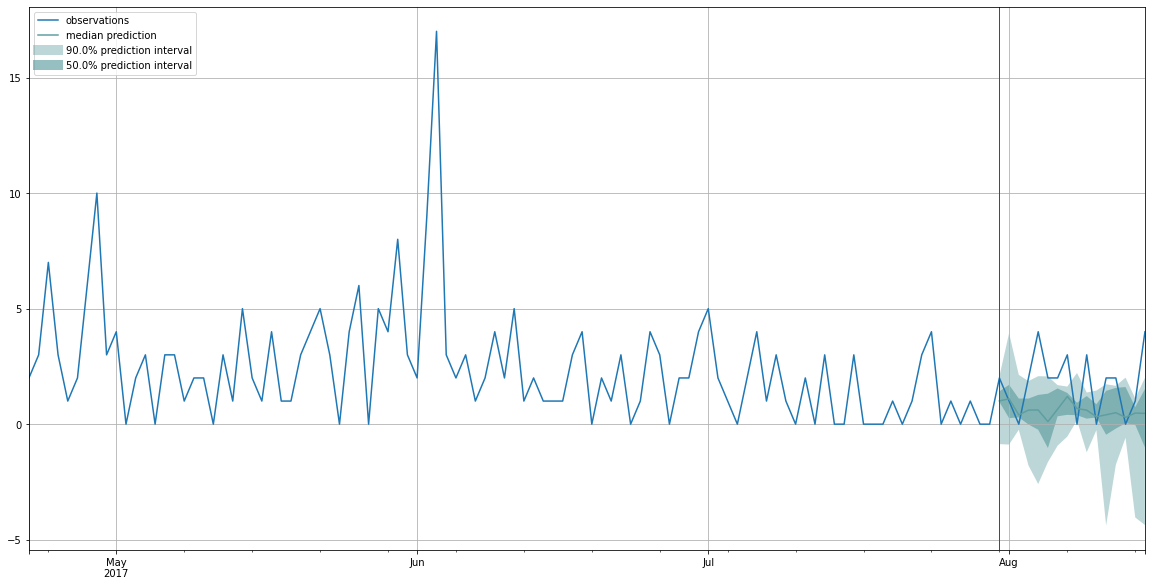

In [46]:
plot_prob_forecasts(
    all_stores_forecasts[1]['tss'][0],
    all_stores_forecasts[1]['forecasts'][0],
    prediction_length,
    (context_length-1900)
)

In [47]:
metrics = gluonts_metrics(all_stores_forecasts[1]['tss'], all_stores_forecasts[1]['forecasts'])
print(json.dumps(metrics, indent=4))

Running evaluation: 33it [00:00, 33.44it/s]

{
    "MSE": 18656.30766778202,
    "abs_error": 24301.61900806427,
    "abs_target_sum": 114829.0,
    "abs_target_mean": 217.47916666666666,
    "seasonal_error": 42.16946847287961,
    "MASE": Infinity,
    "MAPE": 0.46150281301415463,
    "sMAPE": 0.8195638453418558,
    "MSIS": Infinity,
    "QuantileLoss[0.1]": 9910.49918492064,
    "Coverage[0.1]": 0.14204545454545456,
    "QuantileLoss[0.5]": 24301.617892246228,
    "Coverage[0.5]": 0.4318181818181818,
    "QuantileLoss[0.9]": 16895.918810007348,
    "Coverage[0.9]": 0.7821969696969697,
    "RMSE": 136.58809489769604,
    "NRMSE": 0.6280513990889367,
    "ND": 0.21163311539823798,
    "wQuantileLoss[0.1]": 0.08630658792570378,
    "wQuantileLoss[0.5]": 0.21163310568102334,
    "wQuantileLoss[0.9]": 0.1471398236508839,
    "mean_absolute_QuantileLoss": 17036.011962391407,
    "mean_wQuantileLoss": 0.14835983908587033,
    "MAE_Coverage": 0.07601010101010101,
    "OWA": NaN
}



/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:1201: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [54]:
mean_rmse = 0
all_rmse = {}
for store in nb_stores:
    metrics = gluonts_metrics(all_stores_forecasts[store-1]['tss'], all_stores_forecasts[store-1]['forecasts'])
    # print(metrics['RMSE'])
    mean_rmse = mean_rmse + float(metrics['RMSE'])
    all_rmse[store-1] = metrics['RMSE']

rmse = mean_rmse / len(nb_stores)
print("mean RMSE: ", rmse)


Running evaluation: 33it [00:00, 34.13it/s]
/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:1201: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 33it [00:00, 34.36it/s]
Running evaluation: 33it [00:00, 34.54it/s]
Running evaluation: 33it [00:00, 34.73it/s]
Running evaluation: 33it [00:00, 33.90it/s]
Running evaluation: 33it [00:00, 33.94it/s]
Running evaluation: 33it [00:00, 34.26it/s]
Running evaluation: 33it [00:00, 33.61it/s]
Running evaluation: 33it [00:00, 33.49it/s]
Running evaluation: 33it [00:00, 33.83it/s]
Running evaluation: 33it [00:00, 33.69it/s]
Running evaluation: 33it [00:00, 33.99it/s]
Running evaluation: 33it [00:00, 33.78it/s]
Running evaluation: 33it [00:00, 33.33it/s]
Running evaluation: 33it [00:00, 33.37it/s]
Running evaluation: 33it [00:00, 33.38it/s]
Running evaluation: 33it [00:00, 33.80it/s]
Running evaluation: 33it [00:00, 33.98it/s]
Running eva

mean RMSE:  287.9876220374376


In [65]:

all_rmse
print("{:>10} {:>10}".format('STORE', 'RMSE'))
for value in all_rmse.items():
    store, rmse = value
    print("{:>10} {:>10}".format(store, rmse))

{0: 218.38197005829898,
 9: 178.80241801469606,
 10: 145.11220525539352,
 11: 186.75435647260056,
 12: 505.9800605598584,
 13: 332.3637071480795,
 14: 143.75382227230656,
 15: 173.7932398481189,
 16: 340.37515036539963,
 17: 312.19406563377237,
 18: 120.10359510222376,
 1: 136.58809489769604,
 19: 157.54589605506354,
 20: 384.8221686274956,
 21: 295.8477246260527,
 22: 486.7767399705951,
 23: 206.60652662236873,
 24: 279.7482997500811,
 25: 209.3134213079132,
 26: 209.2556945727977,
 27: 220.04486352905425,
 28: 113.91169148716777,
 2: 386.6085890983178,
 29: 282.9304101923438,
 30: 234.44138968512752,
 31: 429.98408768255723,
 32: 414.3225137983869,
 33: 173.36748798577278,
 34: 445.0303488066575,
 35: 389.9769872094697,
 36: 283.5861143830823,
 37: 268.27983800248836,
 38: 669.0858159396727,
 3: 158.05287622881116,
 39: 470.23005125108386,
 40: 474.26180778794173,
 41: 488.7777163271232,
 42: 502.4287856787616,
 43: 397.96299236751,
 44: 121.83034684723077,
 45: 305.9591409098277,
 4

     STORE       RMSE
         0 218.38197005829898
         9 178.80241801469606
        10 145.11220525539352
        11 186.75435647260056
        12 505.9800605598584
        13 332.3637071480795
        14 143.75382227230656
        15 173.7932398481189
        16 340.37515036539963
        17 312.19406563377237
        18 120.10359510222376
         1 136.58809489769604
        19 157.54589605506354
        20 384.8221686274956
        21 295.8477246260527
        22 486.7767399705951
        23 206.60652662236873
        24 279.7482997500811
        25 209.3134213079132
        26 209.2556945727977
        27 220.04486352905425
        28 113.91169148716777
         2 386.6085890983178
        29 282.9304101923438
        30 234.44138968512752
        31 429.98408768255723
        32 414.3225137983869
        33 173.36748798577278
        34 445.0303488066575
        35 389.9769872094697
        36 283.5861143830823
        37 268.27983800248836
        38 669.0858159396727
    

GluonTS multivariate :

<https://github.com/awslabs/gluonts/issues/494>

<https://github.com/awslabs/gluonts/issues/517>

<https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html>

